# In diesem Notebook finden wir eine Regressionsgerade für Hauspreise
Was wir lernen werden:
1. Einlesen einer csv-Datei (Comma Separated Values) mittels pandas
2. Gradient Descent manuell (Loss Funktion, Programmieren des Algorithmus) 
3. Gradient Descent mit Pytorch

In [1086]:
!pip install pandas

## 1. Daten einlesen

In [1087]:
import pandas as pd

# Einlesen der Datei
df = pd.read_csv('22_HousingPrices.csv')

df

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished
...,...,...,...,...,...,...,...,...,...,...,...,...,...
540,1820000,3000,2,1,1,yes,no,yes,no,no,2,no,unfurnished
541,1767150,2400,3,1,1,no,no,no,no,no,0,no,semi-furnished
542,1750000,3620,2,1,1,yes,no,no,no,no,0,no,unfurnished
543,1750000,2910,3,1,1,no,no,no,no,no,0,no,furnished


In [1088]:
# Wir nutzen nur numerische Daten
df = df[['price','area','bedrooms','bathrooms','stories','parking']]
df

,price,area,bedrooms,bathrooms,stories,parking
0,13300000,7420,4,2,3,2
1,12250000,8960,4,4,4,3
2,12250000,9960,3,2,2,2
3,12215000,7500,4,2,2,3
4,11410000,7420,4,1,2,2
...,...,...,...,...,...,...
540,1820000,3000,2,1,1,2
541,1767150,2400,3,1,1,0
542,1750000,3620,2,1,1,0
543,1750000,2910,3,1,1,0


In [1089]:
df.dtypes

price        int64
area         int64
bedrooms     int64
bathrooms    int64
stories      int64
parking      int64
dtype: object

In [1090]:
import torch 
data = torch.tensor(df.values)
data, data.shape

(tensor([[13300000,     7420,        4,        2,        3,        2],
         [12250000,     8960,        4,        4,        4,        3],
         [12250000,     9960,        3,        2,        2,        2],
         ...,
         [ 1750000,     3620,        2,        1,        1,        0],
         [ 1750000,     2910,        3,        1,        1,        0],
         [ 1750000,     3850,        3,        1,        2,        0]]),
 torch.Size([545, 6]))

In [1091]:
# fürs erste nutzen wir nur area zur Vorhersage von price
X = data[:,1:2]
y = data[:,0:1]
X[0], y[0], X.shape, y.shape

(tensor([7420]),
 tensor([13300000]),
 torch.Size([545, 1]),
 torch.Size([545, 1]))

In [1092]:
# Wandlen Datentypen zu float32 um, da später Matrixmultiplikation mit den Gewichten w ausgeführt wird, welche auch float32 sind. Matmul funktioniert nur bei gleichem Datentyp.
X = X.to(torch.float32)
y = y.to(torch.float32)

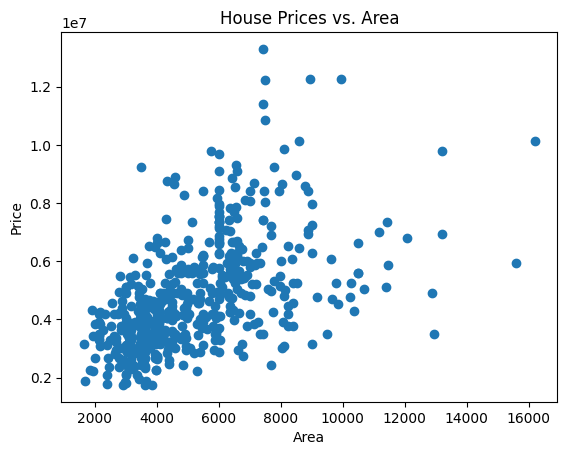

In [1093]:
import matplotlib.pyplot as plt
plt.scatter(X, y)
plt.xlabel('Area')
plt.ylabel('Price')
plt.title('House Prices vs. Area')
plt.show()


Wir sehen, dass die Preise in einer Größenordnung von bis zu $ 10^7 $ vorliegen, währen die Grundstücksfläche in 10^4 vorliegt. <br> Damit es später bei numerischer Berechnung der Gradienten nicht zu Instabilitäten kommt, normieren wir die Werte durch diese Größenordnungen. <br> (Am Ende das Training gerne auch Mal ohne die Normierung ausführen und schauen, wo es zu Fehlern kommt).



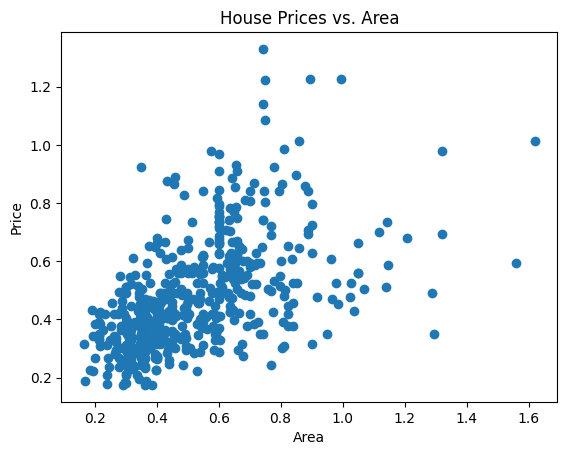

In [1094]:
X = X/(1e4)
y = y/(1e7)
plt.scatter(X, y)
plt.xlabel('Area')
plt.ylabel('Price')
plt.title('House Prices vs. Area')
plt.show()



## 2. Gradient Descent manuell  
Loss/Criterion/Error, der Mean Squared Error:

$ J(\mathbf{w}) = \frac{1}{2n} \sum \left( h_{\mathbf{w}}(x_i) - y_i \right)^2 $

Definieren unser lineares Modell:

price = const + w_1 * area

$ \hat{y}= h_{\mathbf{w}}(x) = w_0 + w_1 x_1 $


Die Gradient Descent Update Regel:

$ \mathbf{w}^{(t+1)} = \mathbf{w}^{(t)} - \alpha \nabla_{\mathbf{w}} J(\mathbf{w}^{(t)}) $

Gradient für \( w_i, Kettenregel \) :

$ \partial_{w_0} J(\mathbf{w}^{(t)}) = \frac{1}{n}\sum  \left( h_{\mathbf{w}}(x_i) - y_i \right) $ 

$ \partial_{w_1} J(\mathbf{w}^{(t)}) = \frac{1}{n}\sum   \left( \left( h_{\mathbf{w}}(x_i) - y_i \right) \cdot xi \right)  $

$ \nabla_{\mathbf{w}} = \left( \partial_{w_0},\partial_{w_1} \right)^T $

Der Algorithmus im Zeitschritt t:
1. Berechne Gradienten mit X, y und w
2. Update w mit Gradienten und alpha
3. Berechne Mean Squared Error J_w(X,y)
4. Falls MSE < Abbruchgrenze: stoppe den Algorithmus, ansonten setze t = t+1 und springe zu Schritt 1

In [1095]:
if X.shape[1] == 1:
    X = torch.cat((torch.ones_like(X), X), dim=1)
X.shape, X

(torch.Size([545, 2]),
 tensor([[1.0000, 0.7420],
         [1.0000, 0.8960],
         [1.0000, 0.9960],
         ...,
         [1.0000, 0.3620],
         [1.0000, 0.2910],
         [1.0000, 0.3850]]))

In [1096]:
# === Aufgabe ===

# 1. Berechne die Gradienten für die Parameter w_0 und w_1
# 2. Update die Parameter mit der Gradient Descent Formel
# 3. Wiederhole den Vorgang, bis die Loss Funktion konvergiert
# wähle einen passenden Wert für alpha

# Zweiter Teil in der nächsten Zelle

# Bemerkung: Wahrscheinlich wirst du bei der Bewältigung der Aufgabe auf viele Matrix-Multiplikationsfehler stoßen,
# hier ist es immer gut, sich die Berechnungen in einer separaten Zelle Schritt für Schritt herzuleiten/anzuschauen.

# === Aufgabe ===

# === Lösung ===



# Definiere h_w
def h_w(X, w):
    # Tipp1: X ist eine Matrix, w ist ein Vektor, y soll Dimension (n,1) haben
    # Tipp2: nutze die Matmul Funktion
    y = torch.matmul(X, w)
    return y

# Berechne den Mean Squared Error
def J_w(X, y, w):
    # berechne die Vorhersagen für y basierend auf X
    y_hat = h_w(X, w)

    # Berechne den Mean Squared Error
    J = 1/2 * torch.mean(torch.pow(y_hat - y, 2))
    return J

# Definiere Gradienten
def grad_J(X, y, w):
    # Achtung: X von der Form (n,2) mit Einsen in der ersten Spalte
    # Mache dir deutlich was xi in der Formel für die partiell Ableitungen bedeutet
    # Rechnung eventuell von Hand auf Papier schreiben oder eine neue Zelle erstellen sich die Shapes und Werte von X, y und w anschauen
    partial_w0 = torch.mean(h_w(X, w) - y)
    partial_w1 = torch.mean((h_w(X,w)-y)*X[:,1:2])
    return torch.tensor([[partial_w0, partial_w1]]).T

# # Definiere Update Regel
# def update_w(X, y, w_0, alpha):
#     
#     # Update Regel
#     w_1 = w_0 - alpha * grad
#     return w_1 

In [1097]:
# Modelltraining
t_max = 1000  # 1000 Iterationen maximal
w_t = torch.rand((2,1))  # Initialisieren die Gewichte w mit Zufallswert 
alpha = 0.1
l = []  # Liste zum Aufsammeln der MSE-Werte für spätere Visualisierung
weights = [w_t]  # Liste zum Aufsammeln der Gewichts-Werte für spätere Visualisierung
grads = []  # Liste zum Aufsammeln der Gradienten für spätere Visualisierung

for t in range(t_max):
    # A: Berechne den numerischen Gradienten
    grad = grad_J(X, y, w_t)

    # A: Definiere die Updateregel 
    w_t = w_t - alpha * grad

    # A: Berechne MSE
    loss = J_w(X, y, w_t)

    l.append(loss)
    weights.append(w_t)
    grads.append([float(grad[0]), float(grad[1])])


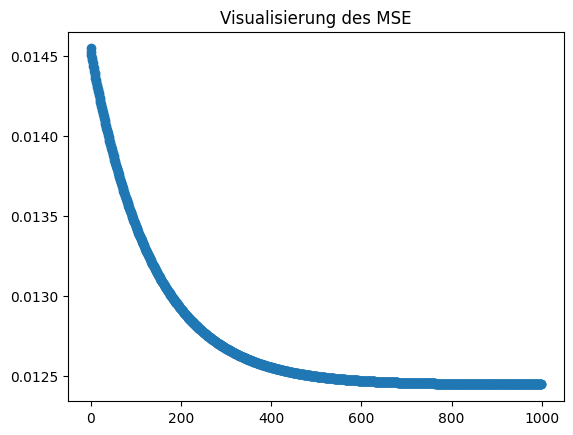

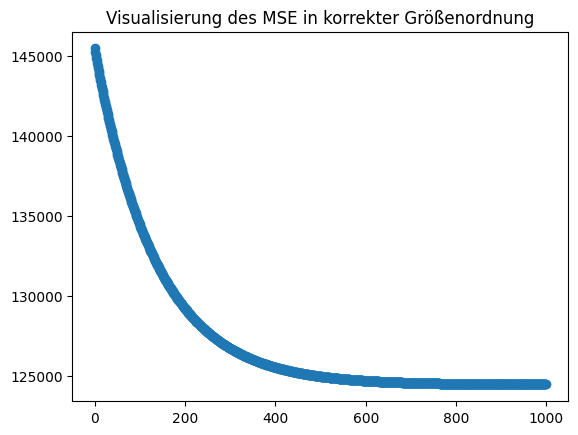

Minimum Average MSE 124456.06291294098


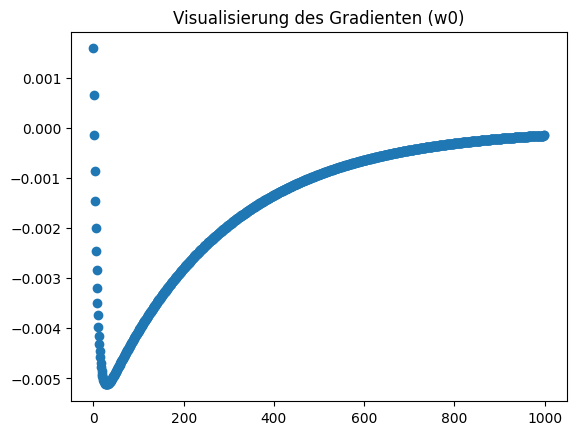

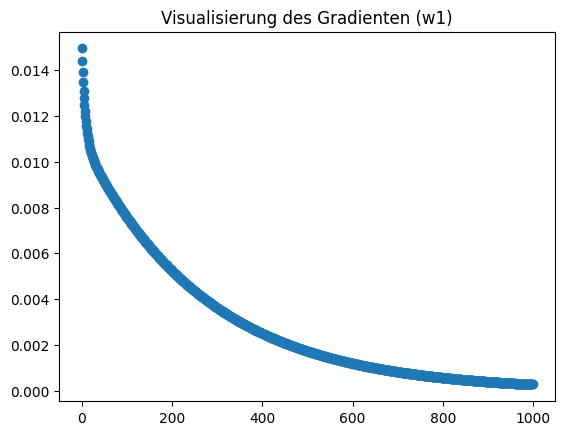

In [1098]:
plt.scatter(range(len(l)), [float(loss) for loss in l])
plt.title('Visualisierung des MSE')
plt.show()
plt.scatter(range(len(l)), [float(loss)*1e7 for loss in l])
plt.title('Visualisierung des MSE in korrekter Größenordnung');
plt.show()
print('Minimum Average MSE', min([float(loss)*1e7 for loss in l]))
plt.scatter(range(len(l)), [g[0] for g in grads])
plt.title('Visualisierung des Gradienten (w0)');
plt.show()
plt.scatter(range(len(l)), [g[1] for g in grads])
plt.title('Visualisierung des Gradienten (w1)');

Wir sehen das das Loss sinkt, würde es auf den Trainingsdaten wieder steigen. hätten wir etwas falsch gecodet! <br>
Die Gradienten sind zu beginn an betragsmäßig groß, d.h. unser Modell lernt hier schnell. Später werden nurnoch kleine Veränderungen an den Gewichten vorgenommen.
Der minimum MSE liegt bei über 100000.

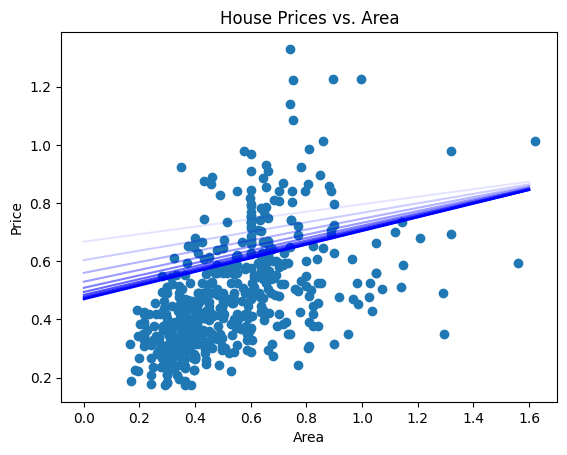

In [1099]:
def plot_line(slope: float, intercept: float, x_range=(0, 1.6), num_points=100, alpha=0.8):
    """
    Plots a line given its slope and y-intercept using PyTorch for calculations.
    
  
    """
    x = torch.linspace(x_range[0], x_range[1], num_points)
    y = slope * x + intercept

    plt.plot(x.numpy(), y.numpy(), color='b', alpha=alpha)
    
plt.scatter(X[:,1], y)
plt.xlabel('Area')
plt.ylabel('Price')
plt.title('House Prices vs. Area')
for i, w in enumerate(weights):
    if (i)%100 == 0:
        plot_line(w[0][0], w[1][0], alpha=min(0.1*(i/100),1))

plt.show()

Mehrere Neuausführungen zeigen, dass das Lineare Modell immer wieder zur Linearen Funktion mit den gleichen Parametern konvergiert. <br> Der MSE/Der Scatterplot indizieren jedoch, dass unser Modell noch keine guten Vorhersagen trifft.


In [1100]:
# Nehmen weitere Features dazu
X_allnumeric = data.to(torch.float32)[:,1:]
X_allnumeric = torch.cat((torch.ones(X_allnumeric.shape[0],1), X_allnumeric),dim=1)
scale_tensor = torch.max(X_allnumeric,dim=0).values.unsqueeze(0)
X_allnumeric = X_allnumeric/ scale_tensor

In [1101]:


def h_w(X, w):
    y = torch.matmul(X, w)
    return y

def J_w(X, y, w):
    y_hat = h_w(X, w)
    J = 1/2 * torch.mean(torch.pow(y_hat - y, 2))
    return J

def grad_J(X, y, w):
    partial_w0 = torch.mean(h_w(X, w) - y)

    # Natürlich könnten wir das auch mit einer einzigen Matrixmultiplikation viel schneller berechnen!
    # h_w shape n, 1
    # y shape n, 1
    # X shape n, d
    other_partials = torch.mean(torch.mul((h_w(X,w)-y), X[:, 1:]),dim=0)

    return torch.cat((partial_w0.unsqueeze(0), other_partials), dim=0).unsqueeze(1)


t_max = 1000  # 1000 Iterationen maximal
w_t = torch.rand((X_allnumeric.shape[1],1))  # Initialisieren die Gewichte w mit Zufallswert 
alpha = 0.1
l = []  # Liste zum Aufsammeln der MSE-Werte für spätere Visualisierung
weights = [w_t]  # Liste zum Aufsammeln der Gewichts-Werte für spätere Visualisierung
grads = []  # Liste zum Aufsammeln der Gradienten für spätere Visualisierung

for t in range(t_max):
    grad = grad_J(X_allnumeric, y, w_t)

    w_t = w_t - alpha * grad

    loss = J_w(X_allnumeric, y, w_t)

    l.append(loss)
    weights.append(w_t)
    grads.append([float(v) for v in grad])

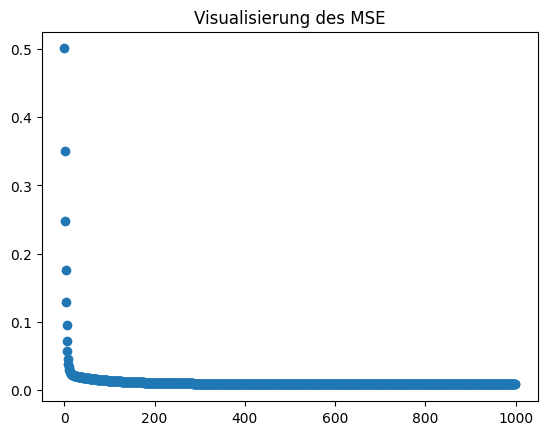

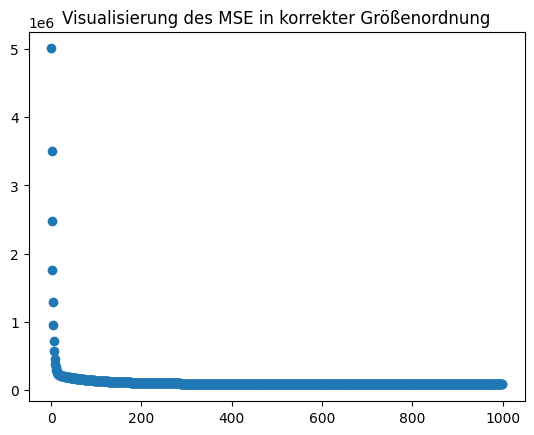

Minimum Average MSE 78126.99303030968


In [1102]:
plt.scatter(range(len(l)), [float(loss) for loss in l])
plt.title('Visualisierung des MSE')
plt.show()
plt.scatter(range(len(l)), [float(loss)*1e7 for loss in l])
plt.title('Visualisierung des MSE in korrekter Größenordnung');
plt.show()
print('Minimum Average MSE', min([float(loss)*1e7 for loss in l]))


Durch hinzufügen der anderen numerischen Werte hat sich der minimum MSE deutlich verringert.

## 3. Gradient Descent mit PyTorch
PyTorch bietet automatische Berechnung des numerischen Gradienten via des Moduls autograd, welchen wir vorhin von Hand berechnet haben (Ableiten/Kettenregel). <br>
Diese Abstraktion vereinfacht den Code und auch die Entwicklung von Algorithmen erheblich. <br> 
Trotzdem kann es sich manchmal lohnen, die Gradienten zu betrachten um Fehler im Code zu finden. <br>

Dank autograd müssen wir nur den "Forward Pass", spezifizieren, also konkret die Berechnung des Losses / MSE in unserem Fall. 


In [1103]:
# Kurzes Beispiel
weight = torch.tensor(4.0, requires_grad=True)
x = torch.tensor(3.0)

f_x = weight * x
f_x 

tensor(12., grad_fn=<MulBackward0>)

In [1104]:
f_x.backward()  # berechnet den numerischen Gradienten für alle tensoren bei denen requires_grad=True spezifiziert wurde


In [1105]:
print('Das ist df_x/dweight, d.h "Wie sehr sich f_x verändern würde, wenn weight sich um eins verändern würde:')
weight.grad

Das ist df_x/dweight, d.h "Wie sehr sich f_x verändern würde, wenn weight sich um eins verändern würde:


tensor(3.)

In [1106]:
# Nochmaliges ausführen von .backward() führt zum Fehler:
f_x.backward() 

RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

In [1072]:
#  Autograd merkt sich den Computational Graph der zum Wert von f_x geführt hat, dieser kann beliebig tief sein
a1 = torch.tensor(2.3, requires_grad=True)
a2 = torch.tensor(1.1, requires_grad=True)
z = torch.tensor(5.0) * (torch.tensor(40.0) * (a2 * ( torch.tensor(3.0) * (torch.tensor(2.0) *a1))))
z.backward()
a1.grad, a2.grad

(tensor(1320.), tensor(2759.9998))

So sieht der Computational Graph aus:
![](2025-03-09-22-27-57.png)

In [1079]:
# Numerische Gradienten können akkumuliert werden, zb wenn unsere Parameter (Weights) zur Berechnung verschiedener Loss Terme verwendet werden
weight = torch.tensor(4.0, requires_grad=True)
x = torch.tensor(3.0)

f_x = weight * x
f_y = weight * x * 10.0 - 2.1
f_x.backward()
weight.grad

tensor(3.)

In [1080]:
f_y.backward()
weight.grad

tensor(33.)

In [1083]:
# Das .grad Attribut kann wieder auf null gesetzt werden, zb wenn der Gradient bereits zum Update benutzt wurde.
weight.grad.zero_()
weight.grad

tensor(0.)

In [1109]:
# Jetzt: Linear Regression mittels Autograd

# Wiederverwenden der Funktionen von oben.

def h_w(X, w):
    y = torch.matmul(X, w)
    return y

# Berechne den Mean Squared Error, Konvention: Nennen J_w = criterion, loss ist das berechnete J_w
def criterion(X, y, w):
    y_hat = h_w(X, w)
    loss = 1/2 * torch.mean(torch.pow(y_hat - y, 2))
    return loss

In [1119]:
w_t

tensor([[0.7731],
        [0.1191]], grad_fn=<SubBackward0>)

In [1152]:
# Diesmal anders: für w_t setzen wir requires_grad = True
w_t = torch.rand((2,1), requires_grad=True) 
alpha = 0.1
l = []  
grads = [] 
grads_autograd = []

for t in range(1000):
    # Berechnung des numerischen Gradienten von vorhin zum Vergleich
    grad_manual = grad_J(X, y, w_t)

    loss = criterion(X, y, w_t)

    # Neu:
    loss.backward()

    # Definiere die Updateregel 
    autograd_grad = w_t.grad 
    w_t = w_t - alpha * autograd_grad 

    # Neu:  w_t muss vom alten Computationalgraph entfernt werden. Hierfür erstellen wir eine Kopie der Tensorwerte von w_t mittels .detach() mit denen wir weiterrechen,
    # und setzen requires_grad wieder auf True:
    w_t = w_t.detach().requires_grad_(True)
   

    l.append(float(loss))
    grads.append([float(grad_manual[0]), float(grad_manual[1])])
    grads_autograd.append([float(autograd_grad[0]), float(autograd_grad[1])])

In [1145]:
l[-1]  # Das Training ended bei ähnlichem Loss wie vorher

0.012450755573809147

In [1158]:
a

tensor([[-2.7015e-01, -1.4582e-01],
        [-2.3563e-01, -1.2735e-01],
        [-2.0551e-01, -1.1124e-01],
        ...,
        [ 1.4140e-05, -2.6449e-05],
        [ 1.4094e-05, -2.6349e-05],
        [ 1.4025e-05, -2.6259e-05]])

In [1156]:
a = torch.tensor(grads)
b = torch.tensor(grads_autograd)
a - b, torch.max(torch.abs(a - b))

(tensor([[-1.1921e-07,  0.0000e+00],
         [-2.9802e-08,  2.9802e-08],
         [-1.4901e-08,  0.0000e+00],
         ...,
         [ 4.2273e-09,  2.8340e-09],
         [ 5.4342e-09,  1.5280e-09],
         [-7.8198e-09,  4.0054e-09]]),
 tensor(1.1921e-07))

Wir sehen, dass die manuel ermittelten Gradienten mit denen, welche von Autograd ermittelt wurden übereinstimmen (Maximale Abweichung in der Größenordnung $10^{-7}$).